In [7]:
###############
### IMPORTS ###
###############

from scipy.io import readsav
import numpy as np
from aiapy.calibrate import degradation, register, update_pointing
from astropy.io import fits
from sunpy.net import Fido, attrs
import sunpy.map
import glob
import os
from sklearn.decomposition import FastICA
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

In [2]:
# Set the date of your dataset:
date='20140313'

In [3]:
datadir='./data/'

In [4]:
# Read-in AIA fits files. These are level 1.5 files (full Sun), 
# rebinned to 1024x1024 and normalised by exposure time (unit: [DN/s])
# Only a subset needed for BSS
fcube304 = fits.open(datadir+'AIA20140313_0304_rbn.fits',mode='readonly')
fcube335 = fits.open(datadir+'AIA20140313_0335_rbn.fits',mode='readonly')
fcube193 = fits.open(datadir+'AIA20140313_0193_rbn.fits',mode='readonly')
fcube211 = fits.open(datadir+'AIA20140313_0211_rbn.fits',mode='readonly')

In [5]:
data304 = fcube304[0].data
data304 = data304.astype(float, copy=False)
hdr304 = fcube304[0].header
data335 = fcube335[0].data
data335 = data335.astype(float, copy=False)
hdr335 = fcube335[0].header
data193 = fcube193[0].data
data193 = data193.astype(float, copy=False)
hdr193 = fcube193[0].header
data211 = fcube211[0].data
data211 = data211.astype(float, copy=False)
hdr211 = fcube211[0].header

In [8]:
ny,nx = data304.shape
AIA304cool_bss = np.zeros((ny,nx))
AIA304hot_bss = np.zeros((ny,nx))

# to identify the different structures in the 304 image it is sufficient to select a subset of all AIA channel images that have some structural overlap with each other (i.e. temperatyure overlap) and include the cool and hot components. 
# Here we select 304, 193, 211 and 335:  
rng = np.random.RandomState(42)
Xi = np.vstack([data304[:,:].reshape(-1),data193[:,:].reshape(-1),data211[:,:].reshape(-1),data335[:,:].reshape(-1)]).T
MEAN=Xi.mean(axis=0)
STD=Xi.std(axis=0)
Xi -= MEAN
Xi /= STD
Sij = np.zeros((ny,nx,2)) 
# we indicate that there are 2 main structural components in the image (cool / hot):
icai = FastICA(n_components=2,whiten="arbitrary-variance",random_state=rng)
Si_ = icai.fit_transform(Xi)
Ai_ = icai.mixing_
Sij[:,:,0] = (Si_[:,0]).reshape((ny,nx))
Sij[:,:,1] = (Si_[:,1]).reshape((ny,nx))
# Calculation of the variance: 
vSij = np.zeros((2))
for j in range(0,2):
    vimg = Sij[:,:,j]*Ai_[0,j]*STD[0]+MEAN[0]/2.
    vSij[j] = np.mean(vimg[400:600,400:600])
# The cool component is usually the one with highest intensity and intensity variation in the on-disk section, here located in the centre of the image.
lcmx = np.argmax(vSij)
#    AIA304_bss[i,:,:] = Ai_[0,0]*Sij[:,:,0]+Ai_[0,1]*Sij[:,:,1]
if (lcmx == 0):
    AIA304cool_bss[:,:] = Ai_[0,lcmx]*Sij[:,:,lcmx]#*STD[0]+MEAN[0]/3.
    AIA304hot_bss[:,:] = Ai_[0,lcmx+1]*Sij[:,:,lcmx+1]#*STD[0]+MEAN[0]/3.
if (lcmx == 1):
    AIA304hot_bss[:,:] = Ai_[0,lcmx-1]*Sij[:,:,lcmx-1]#*STD[0]+MEAN[0]/3.
    AIA304cool_bss[:,:] = Ai_[0,lcmx]*Sij[:,:,lcmx]#*STD[0]+MEAN[0]/3.


Text(0.5, 1.0, 'DN/s')

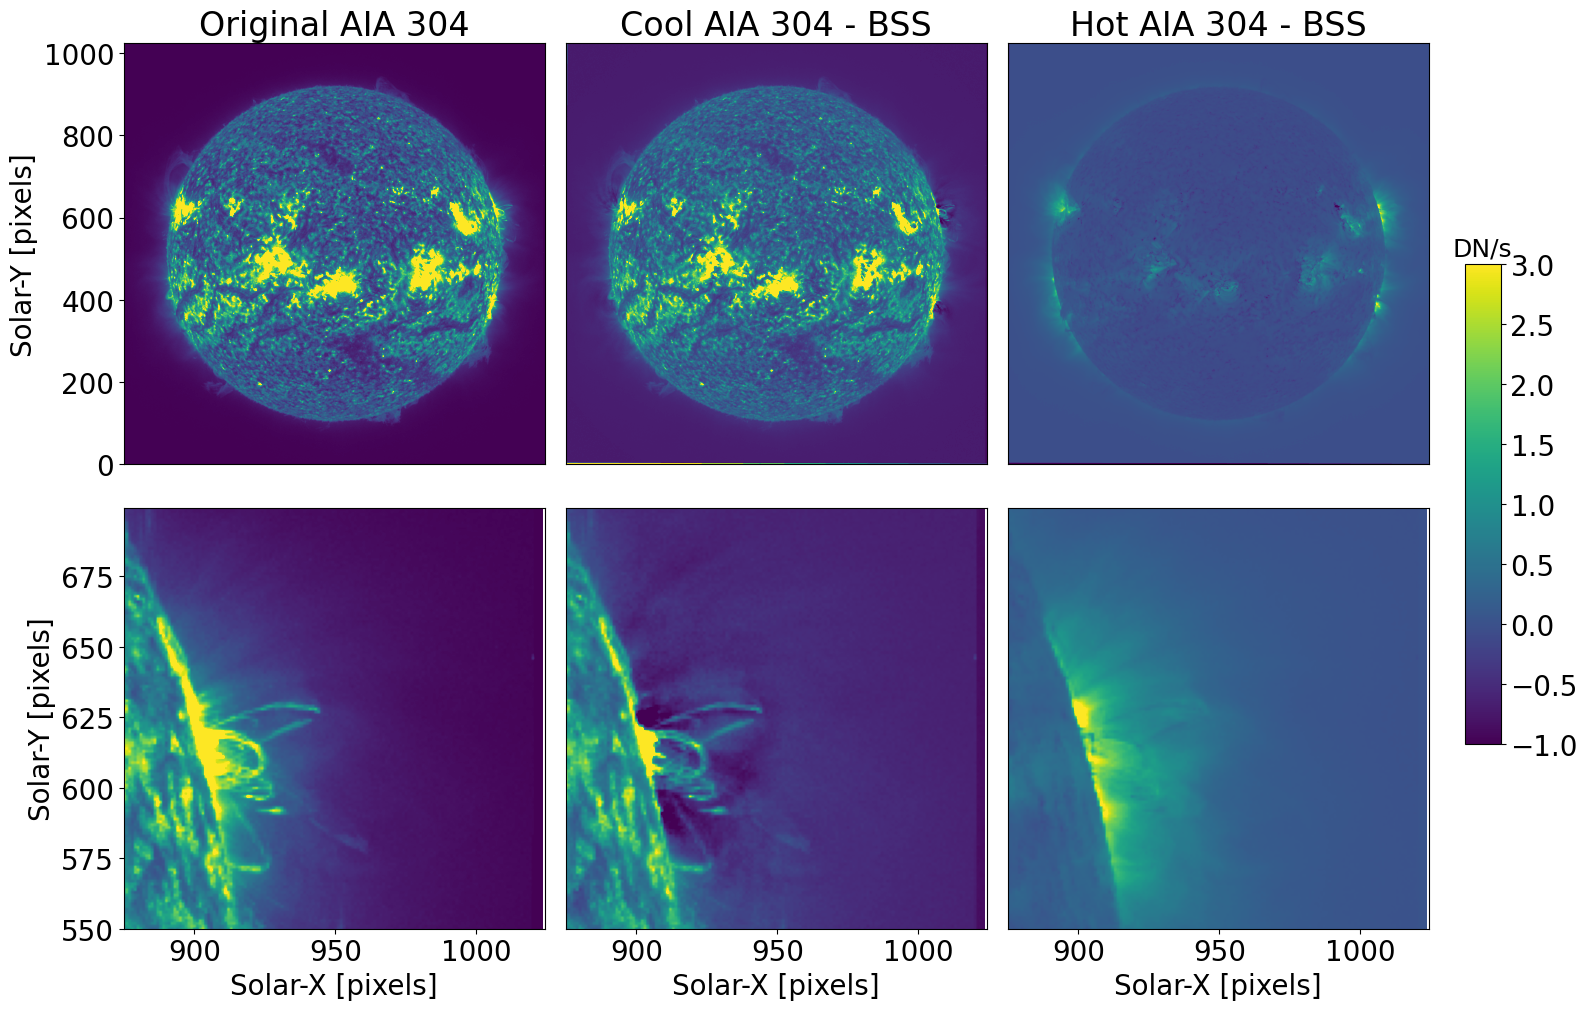

In [ ]:
# Plot result
i = 0
vmax = 40
vminb = -1
vmaxb = 3
x0 = 3500/4
x1 = 4097/4
y0 = 2200/4
y1 = y0+(x1-x0)
plt.rcParams.update({'font.size': 20})
fig,ax=plt.subplots(nrows=2,ncols=3,figsize=(18,12))
fig.subplots_adjust(wspace=0.05,hspace=0.01)
im1 = ax[0,0].imshow(data304,vmin=0,vmax=vmax,origin='lower')
ax[0,0].set_title('Original AIA 304')
ax[0,0].get_xaxis().set_visible(False)
ax[0,0].set_ylabel('Solar-Y [pixels]')
im2 = ax[0,1].imshow(AIA304cool_bss,vmin=vminb,vmax=vmaxb,origin='lower')
ax[0,1].set_title('Cool AIA 304 - BSS')
ax[0,1].get_xaxis().set_visible(False)
ax[0,1].get_yaxis().set_visible(False)
im3 = ax[0,2].imshow(AIA304hot_bss,vmin=vminb,vmax=vmaxb,origin='lower')
ax[0,2].set_title('Hot AIA 304 - BSS')
ax[0,2].get_xaxis().set_visible(False)
ax[0,2].get_yaxis().set_visible(False)
im4 = ax[1,0].imshow(data304,vmin=0,vmax=vmax,origin='lower')
ax[1,0].set_xlabel('Solar-X [pixels]')
ax[1,0].set_ylabel('Solar-Y [pixels]')
ax[1,0].set_xlim(x0,x1)
ax[1,0].set_ylim(y0,y1)
im5 = ax[1,1].imshow(AIA304cool_bss,vmin=vminb,vmax=vmaxb,origin='lower')
ax[1,1].set_xlabel('Solar-X [pixels]')
ax[1,1].get_yaxis().set_visible(False)
ax[1,1].set_xlim(x0,x1)
ax[1,1].set_ylim(y0,y1)
im6 = ax[1,2].imshow(AIA304hot_bss,vmin=vminb,vmax=vmaxb,origin='lower')
ax[1,2].set_xlabel('Solar-X [pixels]')
ax[1,2].get_yaxis().set_visible(False)
ax[1,2].set_xlim(x0,x1)
ax[1,2].set_ylim(y0,y1)

fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.87, 0.28, 0.02, 0.4])
cb = fig.colorbar(im3,cax=cbar_ax)
cb.ax.set_title('DN/s',fontsize=18)